In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import gtfparse

import gseapy as gp
from gseapy import barplot, dotplot


intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

KeyboardInterrupt: 

In [ ]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max

In [ ]:
NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']

long_table_NMD = long_table.loc[long_table.SuperAnnotation.isin(NMD)]
NMD_by_gene = long_table_NMD.groupby(['gene', 'symbol', 'junction']).PSI.mean().reset_index()
NMD_by_gene = NMD_by_gene.groupby(['gene', 'symbol']).PSI.max().reset_index()

RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

polyA_RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
polyA_RPKM.index = [x.split('.')[0] for x in polyA_RPKM.index]

log2polyA_RPKM = polyA_RPKM[polyA_RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2polyA_RPKM.columns = ['gene', 'polyA_RPKM']

NMD_by_gene = NMD_by_gene.merge(log2RPKM, left_on='gene', right_on='gene')

scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(pd.Index(NMD_by_gene.gene))

NMD_by_gene = NMD_by_gene.merge(scores, left_on='gene', right_index=True)

import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

def print_pval(pval):
    if pval > 0.01:
        str_pval = str(round(pval, 2))
    else:
        str_pval = '%.2E' % Decimal(pval)
    return str_pval

def annotate_pval(X, Y, ax, xy = (0.05, 0.1), col='black'):
    
    corr_label = 'Spearman r'
    corr = spearmanr(X, Y)

    str_cor = "{:.2f}".format(corr[0])#str(round(corr[0], 2))
    str_pval = print_pval(corr[1])

    legend = corr_label + ' = ' + str_cor + '\n' + 'pval = ' + str_pval
    ax.annotate(legend, xy=xy, xycoords='axes fraction', c=col)
    
NMD_by_gene = NMD_by_gene.merge(log2polyA_RPKM, left_on='gene', right_on='gene')

In [ ]:
NMD_by_gene['TPM'] = 1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM))
NMD_by_gene['logTPM'] = np.log2(1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM)))
NMD_by_gene['NMD_transcripts'] = NMD_by_gene.TPM*NMD_by_gene.PSI



In [ ]:
NMD_by_gene['polyA_TPM'] = 1e6*np.exp(NMD_by_gene.polyA_RPKM)/np.sum(np.exp(NMD_by_gene.polyA_RPKM))
NMD_by_gene['logpolyA_TPM'] = np.log2(1e6*np.exp(NMD_by_gene.polyA_RPKM)/np.sum(np.exp(NMD_by_gene.polyA_RPKM)))


In [129]:
transcription_factors = []
splicing_factors = []
kinases = []
histone_activity = []
rbps = []
with open('../../c5.all.v2023.1.Hs.symbols.gmt') as fh:#open('../../c5.go.bp.v2023.1.Hs.symbols.gmt') as fh:
    for line in fh:
        line = line.rstrip().split('\t')
        if (line[0][:5] == 'GOBP_') and (('TRANSCRIPTION_FACTOR' in line[0]) or ('TRANSCRIPTION_INITIATION' in line[0]) or ('TRANSCRIPTION_ELONGATION' in line[0])):
            transcription_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('SPLICING' in line[0]) or ('SPLICE_SITE' in line[0])):
            splicing_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and ((('HISTONE' in line[0]) or ('_CHROMATIN_ORGANIZATION' in line[0]) or ('_CHROMATIN_REMODELING' in line[0]))):
            histone_activity.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('KINASE_ACTIVITY' in line[0])):
            kinases.extend(line[2:])
        elif ('GOMF_RNA_BINDING' in line[0]):
            rbps.extend(line[2:])
        
            
transcription_factors = sorted(set(transcription_factors))
splicing_factors = sorted(set(splicing_factors))
kinases = sorted(set(kinases))
histone_activity = sorted(set(histone_activity))
rbps = sorted(set(rbps))

annotation = []
for gene in NMD_by_gene.symbol:
    if gene in transcription_factors:
        annotation.append('Transcription factors')
    elif gene in splicing_factors:
        annotation.append('Splicing factors')
#     elif gene in kinases:
#         annotation.append('Kinases')
#     elif gene in kinases:
#         annotation.append('Kinases')
    elif gene in histone_activity:
        annotation.append('Chromatin factors')
#     elif gene in rbps:
#         annotation.append('Other RBP')
    else:
        annotation.append('Other')
        
NMD_by_gene['annotation'] = annotation

In [75]:
gene_len = RPKM.end - RPKM.start
gene_len.index = [x.split('.')[0] for x in gene_len.index]
gene_len = gene_len.reset_index()
gene_len.columns = ['gene', 'gene_len']

NMD_by_gene = NMD_by_gene.merge(gene_len, left_on='gene', right_on='gene')

{'chRNA': 0.7741125031189479, 'NMD': 0.010035105323568917, 'gene_length': 0.008029314731823996, 'log2_s_score': 0.0007761670966110503}


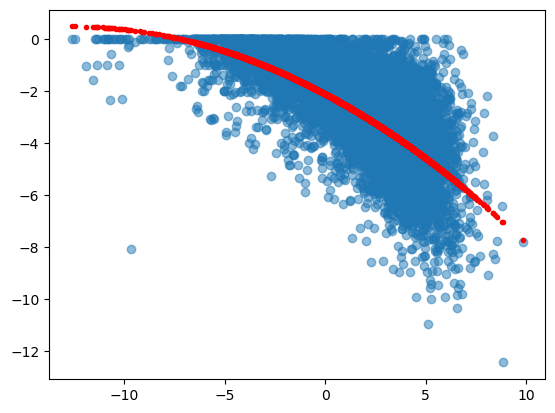

In [76]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *

df = pd.DataFrame()
df['polyA'] = zscore(NMD_by_gene.RPKM)
df['chRNA'] = zscore(NMD_by_gene.polyA_RPKM)
df['NMD'] = zscore(np.log2(NMD_by_gene.PSI))
df['gene_length'] = zscore(np.log2(NMD_by_gene.gene_len))
df['log2_s_score'] = zscore(np.log2(NMD_by_gene.post_mean))

model, r2 = run_regression(df, ['chRNA', 'NMD', 'gene_length', 'log2_s_score'], 'polyA', robust = False)

print(get_var_explained(model.params, r2))

model, r2 = run_regression(df, ['chRNA'], 'NMD', robust = True)



from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x,y, alpha=0.5)
plt.plot(x, poly_pred, color='red', linestyle='', marker='.', lw=0.1);


resid = np.array(y) - poly_pred.T[0]
NMD_by_gene['resid'] = resid

In [77]:
NMD_by_gene['log2_s_score'] = np.log10(NMD_by_gene.post_mean)

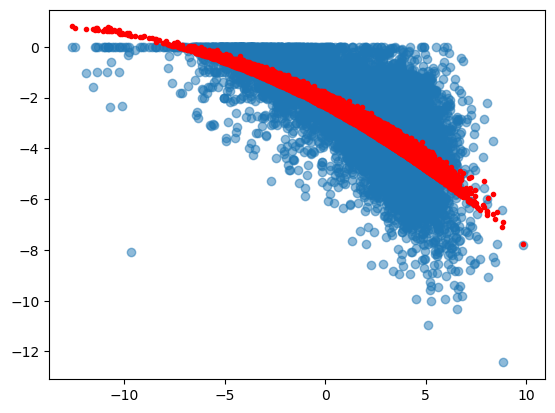

In [78]:
import sys

sys.path.append('../code/scripts/useful_modules')

from plot_functions import *
from regression_functions import *


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = NMD_by_gene[['RPKM', 'log2_s_score']]
y = np.log2(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x))#.reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x.RPKM,y, alpha=0.5)
plt.plot(x.RPKM, poly_pred, color='red', linestyle='', marker='.', lw=0.1);


resid = np.array(y) - poly_pred.T[0]
NMD_by_gene['resid'] = resid

In [172]:
np.linspace(0.1, 1, 10)

def get_slice(df, i, step=0.1):
    qi = df.PSI.quantile(i)
    qi0 = df.PSI.quantile(i-step)
    df_counts = df.loc[(df.PSI <= qi) & (df.PSI >= qi0)]['annotation'].value_counts()
    df_frac = pd.DataFrame(df_counts/1).T
    df_frac.index = ['Q' + str(int((i/step)))]
    return df_frac

In [173]:
NMD_by_gene.columns

Index(['gene', 'symbol', 'PSI', 'RPKM', 'hgnc', 'chrom', 'obs_lof', 'exp_lof',
       'prior_mean', 'post_mean', 'post_lower_95', 'post_upper_95',
       'polyA_RPKM', 'TPM', 'logTPM', 'NMD_transcripts', 'polyA_TPM',
       'logpolyA_TPM', 'annotation', 'gene_len', 'resid', 'log2_s_score'],
      dtype='object')

In [174]:
# df = pd.concat([get_slice(NMD_by_gene, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
# df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'red', 'green', 'purple'])
# plt.title('all genes')

11308

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

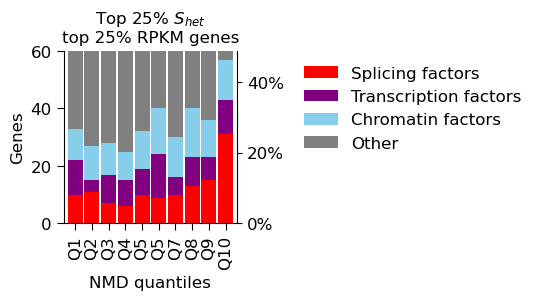

In [236]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,60])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

In [239]:
3*123/(100/15)

55.349999999999994

In [222]:
y

<SecondaryAxis: >

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

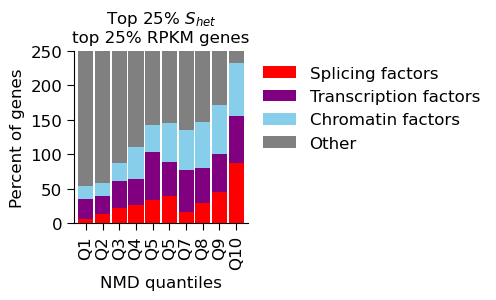

In [176]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene#.loc[
#     (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,250])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Percent of genes', size=12)


figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

In [179]:
from scipy.stats import entropy

nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list, entropy_list]).T
df_summary.columns = ['total_reads', 'total_junctions', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12283/12283 [00:08<00:00, 1485.35it/s]


In [207]:
NMD_by_gene

,gene,symbol,PSI,RPKM,hgnc,chrom,obs_lof,exp_lof,prior_mean,post_mean,...,logpolyA_TPM,annotation,gene_len,resid,log2_s_score,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5+
0,ENSG00000000419,DPM1,0.027426,4.956947,HGNC:3005,chr20,9.0,17.9800,0.015030,0.017280,...,6.855546,Other,23689,-0.648742,-1.762463,0.506329,0.450422,0.043249,0.000000,0.000000
1,ENSG00000000457,SCYL3,0.067388,2.778199,HGNC:19285,chr1,8.0,34.3200,0.009598,0.026510,...,1.466340,Other,44637,-0.398265,-1.576597,0.221184,0.144435,0.138204,0.135089,0.361088
2,ENSG00000000460,C1orf112,0.116244,3.658522,HGNC:25565,chr1,23.0,44.6360,0.003274,0.001609,...,2.383669,Other,192074,0.512054,-2.793371,0.273279,0.146880,0.096752,0.082334,0.400755
3,ENSG00000000938,FGR,0.117739,5.817197,HGNC:3697,chr1,6.0,27.8370,0.033294,0.043014,...,6.799871,Other,23122,2.007880,-1.366386,0.499020,0.171839,0.147174,0.091392,0.090575
4,ENSG00000001036,FUCA2,0.051398,3.147563,HGNC:4008,chr6,14.0,24.2610,0.001359,0.000902,...,4.240763,Other,16909,-0.978928,-3.045015,0.760736,0.239264,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11323,ENSG00000280789,PAGR1,0.036527,2.398451,HGNC:28707,chr16,1.0,8.8160,0.028018,0.165779,...,0.984590,Chromatin factors,6338,-1.335264,-0.780471,1.000000,0.000000,0.000000,0.000000,0.000000
11324,ENSG00000282988,AL031777.2,0.833333,1.041698,HGNC:4767,chr6,4.0,3.4746,0.020204,0.002177,...,-3.505137,Other,3699,2.227715,-2.662181,0.725664,0.230088,0.044248,0.000000,0.000000
11325,ENSG00000284024,AC069544.1,0.391197,3.488467,HGNC:29526,chr10,6.0,29.9440,0.039154,0.052411,...,3.454550,Other,8859,2.537555,-1.280578,1.000000,0.000000,0.000000,0.000000,0.000000
11326,ENSG00000284770,TBCE,0.083500,1.276375,HGNC:11582,chr1,18.0,33.1770,0.004361,0.004579,...,-5.885469,Other,85084,-0.918505,-2.339199,0.388646,0.186135,0.174672,0.078057,0.172489


In [184]:
NMD_by_gene = NMD_by_gene.merge(df_rank, left_on='gene', right_index=True)

In [210]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

In [212]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
long_summary = long_summary.merge(pd.DataFrame(
    exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
    intron_counts = list(df.exon_count)[0]
    intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, intron_counts_list, entropy_list]).T
df_summary.columns = ['total_reads', 'total_junctions', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12283/12283 [00:08<00:00, 1482.47it/s]


In [192]:
top_genes.loc[top_genes.annotation == 'Splicing factors'][['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']].mean(axis=0)

Rank 1     0.615521
Rank 2     0.197420
Rank 3     0.082114
Rank 4     0.041898
Rank 5+    0.063048
dtype: float64

In [194]:
top_genes.loc[top_genes.annotation == 'Transcription factors'][['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']].mean(axis=0)

Rank 1     0.519282
Rank 2     0.203709
Rank 3     0.098746
Rank 4     0.057652
Rank 5+    0.120610
dtype: float64

In [195]:
NMD_by_gene.loc[NMD_by_gene.annotation == 'Splicing factors'][['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']].mean(axis=0)

Rank 1     0.582712
Rank 2     0.199478
Rank 3     0.094126
Rank 4     0.047318
Rank 5+    0.076365
dtype: float64

In [202]:
NMD_by_gene.loc[(NMD_by_gene.PSI > 0.01) & (NMD_by_gene.PSI < 0.2), 
                ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']].mean(axis=0)

Rank 1     0.510227
Rank 2     0.199482
Rank 3     0.102553
Rank 4     0.059975
Rank 5+    0.127763
dtype: float64

In [108]:
from scipy.stats import kruskal, hypergeom

In [125]:
hypergeom.sf(31, 1226, 122, 123)

3.9418721298993264e-08

In [116]:
df

,Other,Transcription factors,Chromatin factors,Splicing factors,Kinases
Q1,82.0,12.0,11.0,10.0,8.0
Q2,89.0,4.0,12.0,11.0,6.0
Q3,85.0,10.0,12.0,7.0,9.0
Q4,90.0,9.0,9.0,6.0,8.0
Q5,84.0,9.0,12.0,10.0,8.0
Q5,75.0,15.0,16.0,9.0,8.0
Q7,88.0,6.0,14.0,10.0,4.0
Q8,81.0,10.0,17.0,14.0,1.0
Q9,80.0,8.0,13.0,14.0,7.0
Q10,64.0,12.0,13.0,31.0,3.0


In [118]:
df.sum(axis=0)

Other                    818.0
Transcription factors     95.0
Chromatin factors        129.0
Splicing factors         122.0
Kinases                   62.0
dtype: float64

In [115]:
122/1226

0.09951060358890701

In [15]:
# top_genes = NMD_by_gene.loc[
#     (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

# df = pd.concat([get_slice(top_genes, i, 0.2) for i in np.linspace(0.2, 1, 5)], axis=0)
# df.plot(kind='bar', stacked=True, color=['grey', 'skyblue', 'green', 'red', 'purple'])
# plt.title(r'Top 25% $S_{het}$, top 25% RPKM genes')

2023-08-15 11:40:37,024 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 11:40:37,120 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 11:40:41,131 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 11:40:52,786 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 20 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'O', 'Q', 'R', 'a', 'd', 'e', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'r', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [

INFO:fontTools.subset:Closing glyph list over 'glyf': 43 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 24, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 43 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.su

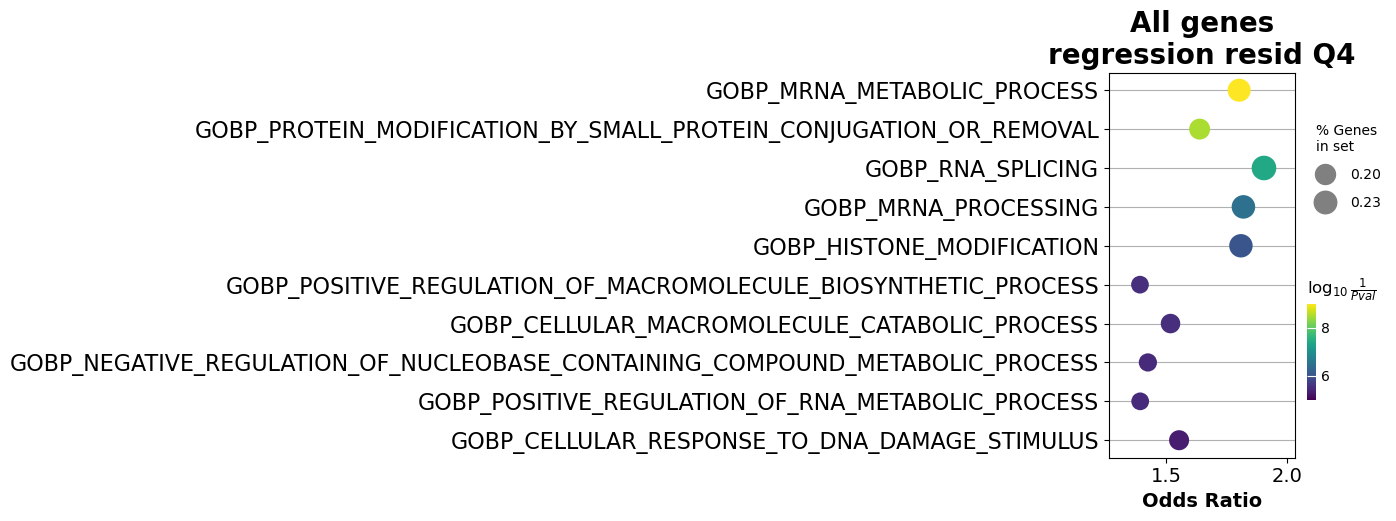

In [16]:
# gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nregression resid Q4',cmap='viridis', size=12, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_resid_Q4.png', dpi=300, bbox_inches='tight',)

2023-08-15 11:40:54,651 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 11:40:54,749 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 11:40:58,686 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 11:41:04,285 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 21 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'I', 'O', 'Q', 'R', 'a', 'd', 'e', 'four', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't']
INFO:fontTools.subset:Glyph IDs

INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 25, 27, 36, 37, 38, 40, 41, 42, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'e', 'eight', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 25, 27, 36, 37, 38, 40, 41, 42, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 66, 72, 74, 76, 79,

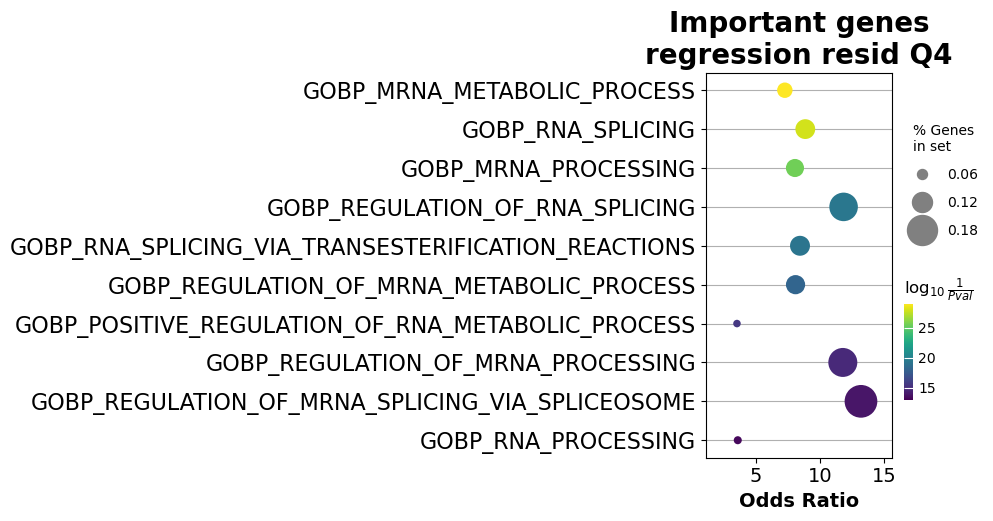

In [17]:
gene_list = list(top_genes.loc[top_genes.resid > top_genes.resid.quantile(0.75)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nregression resid Q4',cmap='viridis', size=20, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')

plt.savefig(figdir + 'Supp_GO_important_genes_resid_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_resid_Q4.png', dpi=300, bbox_inches='tight',)

2023-08-15 14:45:32,344 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 14:45:32,482 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 14:45:36,633 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 14:45:42,060 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'four', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't']
INFO:f

INFO:fontTools.subset:Closing glyph list over 'glyf': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 38 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 

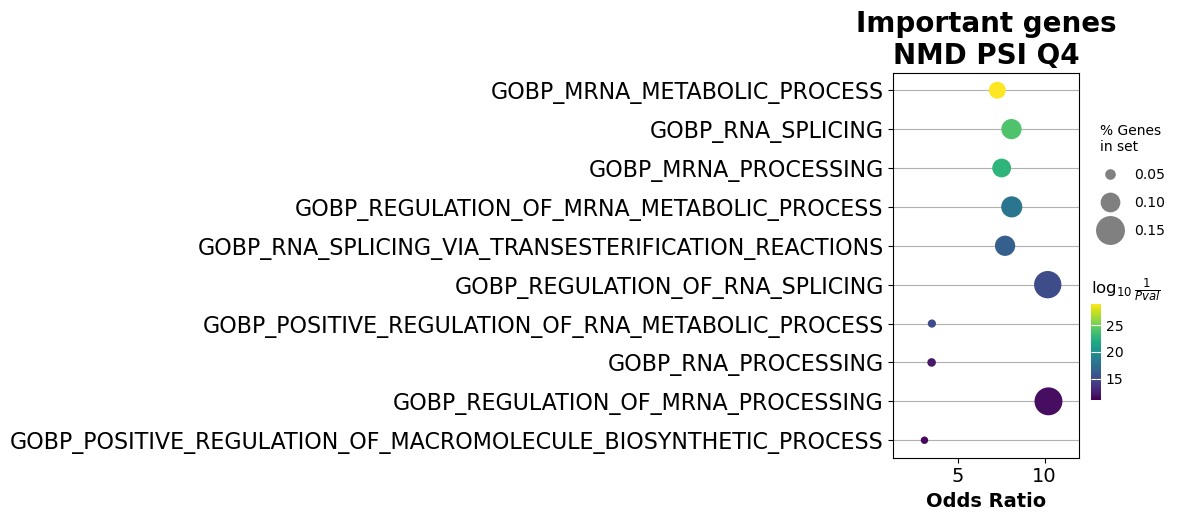

In [38]:
gene_list = list(top_genes.loc[top_genes.PSI > top_genes.PSI.quantile(0.75)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q4',cmap='viridis', size=22, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

In [ ]:
gene_list = list(top_genes.loc[top_genes.PSI > top_genes.PSI.quantile(0.75)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q4',cmap='viridis', size=22, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

2023-08-15 14:46:02,970 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 14:46:03,069 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 14:46:06,864 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 14:46:13,682 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't']
INFO:fo

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'eight', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 

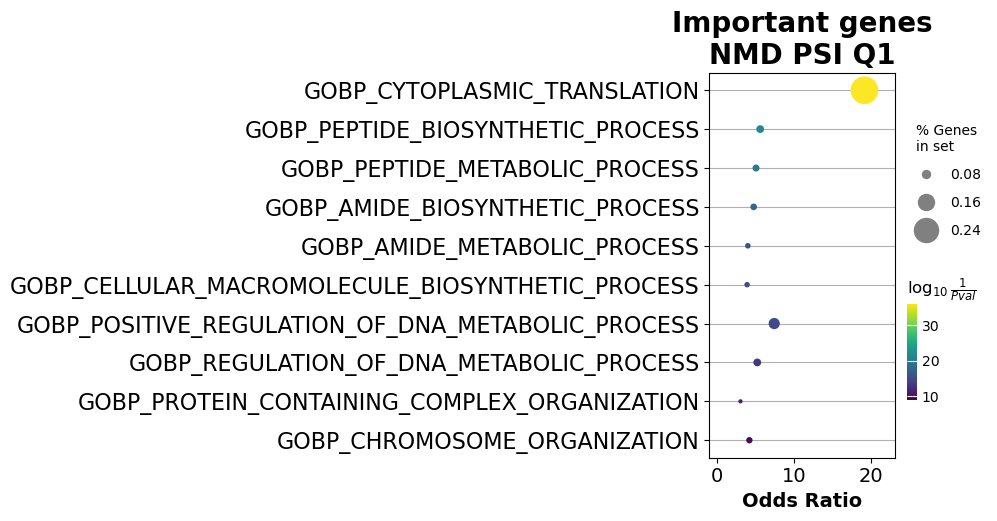

In [39]:
gene_list = list(top_genes.loc[top_genes.PSI < top_genes.PSI.quantile(0.25)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q1',cmap='viridis', size=12, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-15 11:41:16,605 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 11:41:16,703 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 11:41:20,600 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 11:41:24,319 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'R', 'T', 'a', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't', 'two', 'zero']
INFO:fontTools

INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 39, 40, 41, 42, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 37 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 24, 36, 37, 38, 39, 40, 41, 42, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTool

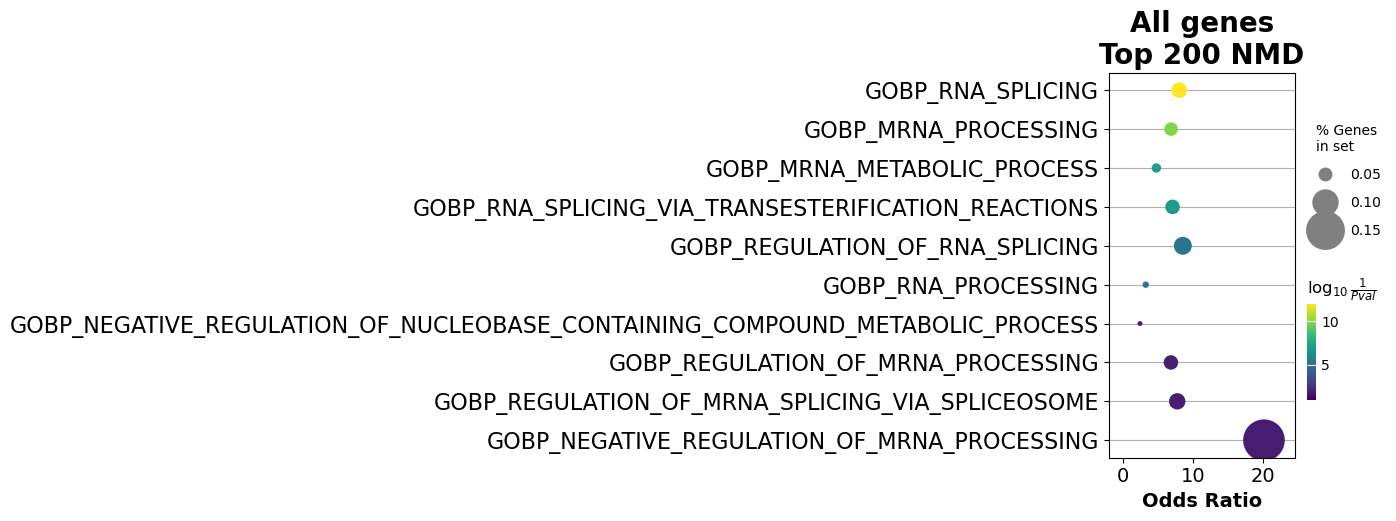

In [19]:
gene_list = list(NMD_by_gene.sort_values('resid').symbol)[-200:]
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop 200 NMD',cmap='viridis', size=30, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')

plt.savefig(figdir + 'Supp_GO_all_genes_NMD_top200.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_top200.png', dpi=300, bbox_inches='tight',)

2023-08-15 11:41:25,915 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 11:41:26,020 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 11:41:29,972 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 11:41:41,485 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't']
INFO:fontTools.s

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 

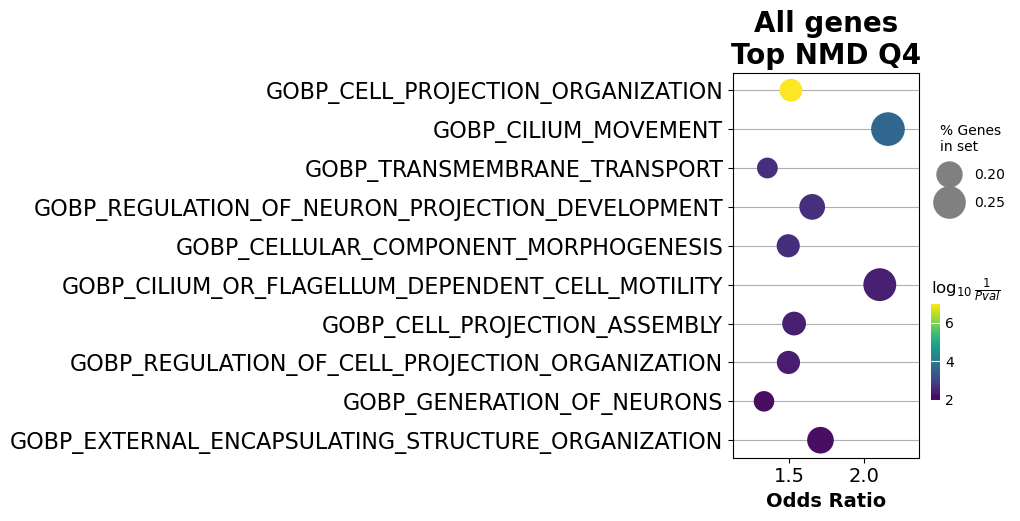

In [20]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI > NMD_by_gene.PSI.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q4',cmap='viridis', size=15, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

2023-08-15 14:54:41,096 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-15 14:54:41,243 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-15 14:54:45,054 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-15 14:54:56,945 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't']
INFO:fontTools.su

INFO:fontTools.subset:Closing glyph list over 'glyf': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 41 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 

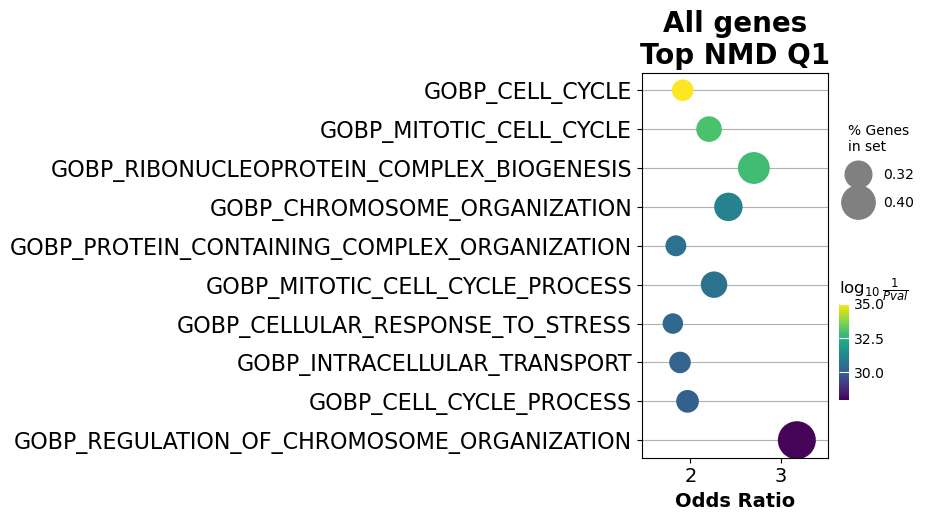

In [42]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI < NMD_by_gene.PSI.quantile(0.25)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q1',cmap='viridis', size=10, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'a', 'c', 'e', 'five', 'four', 'g', 'i', 'j', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 36, 37, 38, 39, 41, 44, 46, 47, 48, 49, 51, 53, 54, 68, 70, 72, 74, 76, 77, 79, 81, 82, 86, 87, 88, 91, 3228]
INFO:

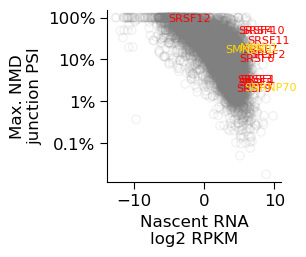

In [25]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)


x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

In [23]:
other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


In [24]:
other_sf_ensembl

Index(['ENSG00000152601', 'ENSG00000119953', 'ENSG00000104852'], dtype='object')

In [35]:
(NMD_by_gene.PSI > 0.02).sum()

10556

In [36]:
NMD_by_gene.PSI.median()

0.09847984934293683

In [241]:
NMD_by_gene.loc[NMD_by_gene.symbol.isin(other_sf + srsf)]

,gene,symbol,PSI,RPKM,hgnc,chrom,obs_lof,exp_lof,prior_mean,post_mean,...,logpolyA_TPM,annotation,gene_len,resid,log2_s_score,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5+
1714,ENSG00000100650,SRSF5,0.029484,5.418160,HGNC:10787,chr14,3.0,16.9510,0.324941,0.210584,...,6.988974,Splicing factors,45106,-0.076047,-0.676574,0.714602,0.227530,0.057868,0.000000,0.000000
2097,ENSG00000104852,SNRNP70,0.022498,6.172447,HGNC:11150,chr19,1.0,25.2210,0.448500,0.568341,...,7.014519,Splicing factors,23187,0.028634,-0.245391,0.534080,0.400143,0.065777,0.000000,0.000000
2784,ENSG00000111786,SRSF9,0.021375,5.027585,HGNC:10791,chr12,2.0,11.9080,0.268451,0.234189,...,6.222822,Splicing factors,8077,-0.746909,-0.630433,0.987934,0.012066,0.000000,0.000000,0.000000
2818,ENSG00000112081,SRSF3,0.035381,5.288809,HGNC:10785,chr6,0.0,10.2870,0.636952,0.708122,...,7.681782,Splicing factors,11248,0.192404,-0.149892,0.578490,0.349657,0.067277,0.004577,0.000000
3169,ENSG00000115875,SRSF7,0.184946,5.885160,HGNC:10789,chr2,2.0,21.0670,0.554179,0.405139,...,7.396735,Splicing factors,7896,2.880759,-0.392396,0.669499,0.158707,0.076232,0.065037,0.030525
3226,ENSG00000116350,SRSF4,0.510905,5.409326,HGNC:10786,chr1,4.0,24.2060,0.464432,0.274350,...,5.680345,Splicing factors,34158,4.052795,-0.561695,0.401939,0.270538,0.102867,0.079498,0.145158
3270,ENSG00000116754,SRSF11,0.303682,6.631781,HGNC:10782,chr1,2.0,27.0630,0.438709,0.521930,...,6.130086,Splicing factors,47371,4.046229,-0.282388,0.437030,0.153072,0.137418,0.085132,0.187347
3543,ENSG00000119953,SMNDC1,0.178577,3.552722,HGNC:16900,chr10,2.0,11.8910,0.257506,0.148437,...,4.485683,Splicing factors,14209,1.512650,-0.828457,0.458457,0.289311,0.141680,0.067750,0.042802
3846,ENSG00000124193,SRSF6,0.109299,5.514852,HGNC:10788,chr20,3.0,20.9980,0.255916,0.171838,...,5.999719,Splicing factors,8154,1.852725,-0.764880,0.837790,0.147183,0.014256,0.000771,0.000000
5010,ENSG00000136450,SRSF1,0.035131,5.674698,HGNC:10780,chr17,0.0,12.3510,0.547772,0.628204,...,6.300888,Splicing factors,6428,0.392480,-0.201900,0.433739,0.408251,0.098625,0.059385,0.000000


In [246]:
NMD_by_gene.loc[(NMD_by_gene.RPKM > NMD_by_gene.RPKM.quantile(0.75)) & (NMD_by_gene.symbol.isin(other_sf + srsf))]

,gene,symbol,PSI,RPKM,hgnc,chrom,obs_lof,exp_lof,prior_mean,post_mean,...,logpolyA_TPM,annotation,gene_len,resid,log2_s_score,Rank 1,Rank 2,Rank 3,Rank 4,Rank 5+
1714,ENSG00000100650,SRSF5,0.029484,5.418160,HGNC:10787,chr14,3.0,16.9510,0.324941,0.210584,...,6.988974,Splicing factors,45106,-0.076047,-0.676574,0.714602,0.227530,0.057868,0.000000,0.000000
2097,ENSG00000104852,SNRNP70,0.022498,6.172447,HGNC:11150,chr19,1.0,25.2210,0.448500,0.568341,...,7.014519,Splicing factors,23187,0.028634,-0.245391,0.534080,0.400143,0.065777,0.000000,0.000000
2784,ENSG00000111786,SRSF9,0.021375,5.027585,HGNC:10791,chr12,2.0,11.9080,0.268451,0.234189,...,6.222822,Splicing factors,8077,-0.746909,-0.630433,0.987934,0.012066,0.000000,0.000000,0.000000
2818,ENSG00000112081,SRSF3,0.035381,5.288809,HGNC:10785,chr6,0.0,10.2870,0.636952,0.708122,...,7.681782,Splicing factors,11248,0.192404,-0.149892,0.578490,0.349657,0.067277,0.004577,0.000000
3169,ENSG00000115875,SRSF7,0.184946,5.885160,HGNC:10789,chr2,2.0,21.0670,0.554179,0.405139,...,7.396735,Splicing factors,7896,2.880759,-0.392396,0.669499,0.158707,0.076232,0.065037,0.030525
3226,ENSG00000116350,SRSF4,0.510905,5.409326,HGNC:10786,chr1,4.0,24.2060,0.464432,0.274350,...,5.680345,Splicing factors,34158,4.052795,-0.561695,0.401939,0.270538,0.102867,0.079498,0.145158
3270,ENSG00000116754,SRSF11,0.303682,6.631781,HGNC:10782,chr1,2.0,27.0630,0.438709,0.521930,...,6.130086,Splicing factors,47371,4.046229,-0.282388,0.437030,0.153072,0.137418,0.085132,0.187347
3846,ENSG00000124193,SRSF6,0.109299,5.514852,HGNC:10788,chr20,3.0,20.9980,0.255916,0.171838,...,5.999719,Splicing factors,8154,1.852725,-0.764880,0.837790,0.147183,0.014256,0.000771,0.000000
5010,ENSG00000136450,SRSF1,0.035131,5.674698,HGNC:10780,chr17,0.0,12.3510,0.547772,0.628204,...,6.300888,Splicing factors,6428,0.392480,-0.201900,0.433739,0.408251,0.098625,0.059385,0.000000
6509,ENSG00000152601,MBNL1,0.206846,5.649577,HGNC:6923,chr3,4.0,21.5280,0.203923,0.078914,...,7.400522,Splicing factors,221953,2.784074,-1.102846,0.328195,0.185297,0.168178,0.082475,0.235855
